<a href="https://colab.research.google.com/github/buisonanh/phishing_urls_detection/blob/main/phishing_urls_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prepare Data**

In [782]:
import numpy as np
import pandas as pd

In [783]:
# Import data
legit = pd.read_csv("datasets/FinalDataset/URL/Benign_list_big_final.csv")
phishing = pd.read_csv("datasets/FinalDataset/URL/phishing_dataset.csv")
malware = pd.read_csv("datasets/FinalDataset/URL/Malware_dataset.csv")
spam = pd.read_csv("datasets/FinalDataset/URL/spam_dataset.csv")


In [784]:
legit.columns = ['url']

phishing.columns = ['url']
malware.columns = ['url']
spam.columns = ['url']

malicious = pd.concat([phishing, malware, spam])

In [785]:
# Drop duplicates
legit.drop_duplicates()
malicious.drop_duplicates()

print(legit.info())
print()
print(malicious.info())
print()

# Check null values
print(f"Legit null values: {legit.isnull().sum()}")
print(f"Phishing null values: {malicious.isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35377 entries, 0 to 35376
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     35377 non-null  object
dtypes: object(1)
memory usage: 276.5+ KB
None

<class 'pandas.core.frame.DataFrame'>
Index: 33528 entries, 0 to 11998
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     33528 non-null  object
dtypes: object(1)
memory usage: 523.9+ KB
None

Legit null values: url    0
dtype: int64
Phishing null values: url    0
dtype: int64


In [786]:
# add a 'label' column to the dataframes
legit["label"] = 0
malicious["label"] = 1

print(legit)
# combine the two dataframes
df = pd.concat([legit, malicious], ignore_index=True)

# shuffle the dataframe's rows randomly
df = df.sample(frac=1, random_state=42) # Set random_state to an integer for reproducibility

df.info()

                                                     url  label
0      http://1337x.to/torrent/1110018/Blackhat-2015-...      0
1      http://1337x.to/torrent/1122940/Blackhat-2015-...      0
2      http://1337x.to/torrent/1124395/Fast-and-Furio...      0
3      http://1337x.to/torrent/1145504/Avengers-Age-o...      0
4      http://1337x.to/torrent/1160078/Avengers-age-o...      0
...                                                  ...    ...
35372  https://lastpass.com/signup2.php?ac=1&from_uri...      0
35373  https://lastpass.com/signup2.php?ac=1&from_uri...      0
35374  https://lastpass.com/signup2.php?ac=1&from_uri...      0
35375  https://lastpass.com/signup2.php?ac=1&from_uri...      0
35376  https://asana.com/guide/videos/%22//fast.wisti...      0

[35377 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 68905 entries, 38874 to 15795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     68905 non-null

In [787]:
# Identify duplicate rows
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicates: {num_duplicates}")

df = df.drop_duplicates()

duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicates: {num_duplicates}")


Number of duplicates: 8962
Number of duplicates: 0


In [788]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59943 entries, 38874 to 15795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     59943 non-null  object
 1   label   59943 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [789]:
print(df.isnull().sum())
df.dropna(inplace = True)

df.head(10)

url      0
label    0
dtype: int64


,url,label
38874,http://www.dongyuwl.com/images/?ref=http%3A%2F...,1
32003,http://web.de/magazine/sport/fussball/champion...,0
24710,http://akhbarelyom.com/news/newdetails/411482/...,0
19366,http://nypost.com/2015/05/13/suspect-in-brazen...,0
40527,http://davemenkehorst.com/wp-content/uploads/2...,1
1836,https://prezi.com/ytniorzhkciw/mrs-sporty-inte...,0
64392,http://acard4u.co.uk/product_reviews.php?produ...,1
21144,http://lifehacker.com/5813835/from-the-tips-bo...,0
48579,http://9779.info/%E6%9C%89%E5%85%B3%E7%BA%B8%E...,1
63957,http://aolshop.memberoffers.co.uk/csp/smp/aol/...,1


In [790]:
"""
# assume `data` is a pandas DataFrame with columns "url" and "label"
counts = df["label"].value_counts()

# print the counts for each category
print(counts)
"""

'\n# assume `data` is a pandas DataFrame with columns "url" and "label"\ncounts = df["label"].value_counts()\n\n# print the counts for each category\nprint(counts)\n'

# **Extracting Features**

In [791]:
# importing required packages for this section
from urllib.parse import urlparse,urlencode
import ipaddress
import re

# 1.Domain of the URL (Domain) 
def getDomain(url):  
    domain = urlparse(url).netloc
    if re.match(r"^www.",domain):
            domain = domain.replace("www.","")
    return domain

# 2.Checks for IP address in URL (Have_IP)
def havingIP(url):
    try:
        ipaddress.ip_address(url)
        ip = 1
    except:
        ip = 0
    return ip

# 3.Checks the presence of @ in URL (Have_At)
def haveAtSign(url):
    if "@" in url:
        at = 1    
    else:
        at = 0    
    return at

# 4.Finding the length of URL and categorizing (URL_Length)
def getLength(url):
    if len(url) < 54:
        length = 0            
    else:
        length = 1            
    return length

# 5.Gives number of '/' in URL (URL_Depth)
def getDepth(url):
    s = urlparse(url).path.split('/')
    depth = 0
    for j in range(len(s)):
        if len(s[j]) != 0:
            depth = depth+1
    return depth

# 6.Checking for redirection '//' in the url (Redirection)
def redirection(url):
    pos = url.rfind('//')
    if pos > 6:
        if pos > 7:
            return 1
        else:
            return 0
    else:
        return 0

# 7.Existence of “HTTPS” Token in the Domain Part of the URL (https_Domain)
def httpDomain(url):
    domain = urlparse(url).netloc
    if 'https' in domain:
        return 1
    else:
        return 0

In [792]:
def featureExtraction(url,label):
    
    features = []
    features.append(url)
    #Address bar based features (10)
    features.append(getDomain(url))
    features.append(havingIP(url))
    features.append(haveAtSign(url))
    features.append(getLength(url))
    features.append(getDepth(url))
    features.append(redirection(url))
    features.append(httpDomain(url))
    features.append(label)

    return features

In [793]:
df.shape

(59943, 2)

In [794]:
df.reset_index(drop=True, inplace=True)
df.head(30)

,url,label
0,http://www.dongyuwl.com/images/?ref=http%3A%2F...,1
1,http://web.de/magazine/sport/fussball/champion...,0
2,http://akhbarelyom.com/news/newdetails/411482/...,0
3,http://nypost.com/2015/05/13/suspect-in-brazen...,0
4,http://davemenkehorst.com/wp-content/uploads/2...,1
5,https://prezi.com/ytniorzhkciw/mrs-sporty-inte...,0
6,http://acard4u.co.uk/product_reviews.php?produ...,1
7,http://lifehacker.com/5813835/from-the-tips-bo...,0
8,http://9779.info/%E6%9C%89%E5%85%B3%E7%BA%B8%E...,1
9,http://aolshop.memberoffers.co.uk/csp/smp/aol/...,1


In [795]:
features = []

for i in range(len(df)):
    url = df['url'][i]
    label = df['label'][i]

    features.append(featureExtraction(url,label))

In [796]:
#converting the list to dataframe
feature_names = ['url', 'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection','https_Domain', 'label']

df = pd.DataFrame(features, columns= feature_names)
df[1:10000]

,url,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,label
1,http://web.de/magazine/sport/fussball/champion...,web.de,0,0,1,6,0,0,0
2,http://akhbarelyom.com/news/newdetails/411482/...,akhbarelyom.com,0,0,1,5,0,0,0
3,http://nypost.com/2015/05/13/suspect-in-brazen...,nypost.com,0,0,1,4,0,0,0
4,http://davemenkehorst.com/wp-content/uploads/2...,davemenkehorst.com,0,0,1,5,0,0,1
5,https://prezi.com/ytniorzhkciw/mrs-sporty-inte...,prezi.com,0,0,1,2,0,0,0
...,...,...,...,...,...,...,...,...,...
9995,http://kenh14.vn/tv-show/guong-mat-than-quen-m...,kenh14.vn,0,0,1,2,0,0,0
9996,http://haberler.com/gaziantep-te-karsit-gorusl...,haberler.com,0,0,1,2,0,0,0
9997,http://www.superbemmasfacileseguro.vai.la/,superbemmasfacileseguro.vai.la,0,0,0,0,0,0,1
9998,http://hollywoodlife.com/2015/03/28/iggy-azale...,hollywoodlife.com,0,0,1,4,0,0,0


In [797]:
df.isnull().sum()

url             0
Domain          0
Have_IP         0
Have_At         0
URL_Length      0
URL_Depth       0
Redirection     0
https_Domain    0
label           0
dtype: int64

In [798]:
# delete symbols
import re
df["url"] = df["url"].apply(lambda x: re.sub('[/\.;?=https:\']', ' ', x))

# **Vectorizing and Encoding**

In [799]:
# Data selection
url_df = df['url']
domain_df = df['Domain']
depth_df = df['URL_Depth']
feature_df = df[['Have_IP', 'Have_At', 'URL_Length','Redirection','https_Domain']]
label_df = df['label']

In [800]:
depth_arr = np.asarray(depth_df)
depth_arr

import numpy as np
from sklearn import preprocessing

# Reshape depth_arr to a 2D array
depth_arr_2d = np.reshape(depth_arr, (-1, 1))

# Apply StandardScaler
scaler = preprocessing.StandardScaler().fit(depth_arr_2d)
depth_scaler = scaler.transform(depth_arr_2d)
depth_scaler[:5]



array([[-1.17272134],
       [ 1.51669244],
       [ 0.97880968],
       [ 0.44092693],
       [ 0.97880968]])

In [801]:
# Transform data
from sklearn.feature_extraction.text import CountVectorizer

import scipy.sparse as sp

# Vectorize URLs
vectorizer_url = CountVectorizer()
url_vec = vectorizer_url.fit_transform(url_df)

# Vectorize Domains
vectorizer_domain = CountVectorizer()
domain_vec = vectorizer_domain.fit_transform(domain_df)

features_arr = np.asarray(feature_df)

# Convert depth_arr_2d to a sparse matrix
depth_sparse = sp.csr_matrix(depth_arr_2d)

# Concatenate url_vec, domain_vec, and features_arr as sparse matrices
combined_features_arr = sp.hstack((url_vec, domain_vec, sp.csr_matrix(features_arr), depth_sparse), format='csr')

# Encode label column
label_arr = np.asarray(label_df)



In [802]:
label_arr

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [803]:
"""
from imblearn.over_sampling import RandomOverSampler

# create a RandomOverSampler object and fit it to the data
oversampler = RandomOverSampler(random_state=42)
combined_features_arr_balanced, label_arr_balanced = oversampler.fit_resample(combined_features_arr, label_arr)

# check the new class distribution
pd.Series(label_arr_balanced).value_counts()
"""

'\nfrom imblearn.over_sampling import RandomOverSampler\n\n# create a RandomOverSampler object and fit it to the data\noversampler = RandomOverSampler(random_state=42)\ncombined_features_arr_balanced, label_arr_balanced = oversampler.fit_resample(combined_features_arr, label_arr)\n\n# check the new class distribution\npd.Series(label_arr_balanced).value_counts()\n'

# **Logistic Regression**

In [804]:
# chia tap train, test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(combined_features_arr, label_arr, test_size=0.25, random_state=42)

print('Train: ', x_train.shape[0])
print('Test: ', x_test.shape[0])

Train:  44957
Test:  14986


In [805]:

# modeling lbfgs
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C= 0.01, class_weight= None, max_iter= 500, penalty= 'l2',random_state=42)
lr_lbfgs = logreg.fit(x_train,y_train)


In [806]:
"""
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l1', 'l2'],
              'max_iter': [100, 500, 1000],
              'class_weight': [None, 'balanced']}

grid_search = GridSearchCV(LogisticRegression(solver='lbfgs'),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")


# Output:
# Best parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2'}
# Best cross-validation score: 0.9967524463965745
"""

'\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = {\'C\': [0.001, 0.01, 0.1, 1, 10],\n              \'penalty\': [\'l1\', \'l2\'],\n              \'max_iter\': [100, 500, 1000],\n              \'class_weight\': [None, \'balanced\']}\n\ngrid_search = GridSearchCV(LogisticRegression(solver=\'lbfgs\'),\n                           param_grid,\n                           cv=5,\n                           scoring=\'accuracy\',\n                           n_jobs=-1)\n\ngrid_search.fit(x_train, y_train)\n\nprint(f"Best parameters: {grid_search.best_params_}")\nprint(f"Best cross-validation score: {grid_search.best_score_}")\n\n\n# Output:\n# Best parameters: {\'C\': 10, \'class_weight\': \'balanced\', \'max_iter\': 500, \'penalty\': \'l2\'}\n# Best cross-validation score: 0.9967524463965745\n'

In [807]:
y_pred=logreg.predict(x_test)
print(y_pred)

[0 0 1 ... 1 0 1]


In [808]:
from sklearn.metrics import jaccard_score
print(f"Jaccard score: {jaccard_score(y_test, y_pred,pos_label=0)}")

Jaccard score: 0.9531537379638646


In [809]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")


Accuracy: 0.97
F1 score: 0.96


In [810]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[8810,   63],
       [ 370, 5743]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

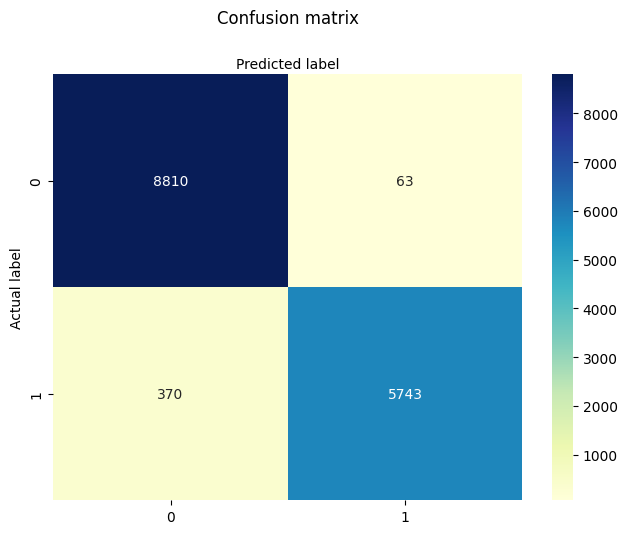

In [811]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# **(Test)**

In [812]:
test_df = pd.read_csv('datasets/publish_test.csv')
test_df.head(30)

,x,y,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,http://newmatdesign.ro/wp-admin/wewe/YAHOO/ya....,1,NaN,NaN,NaN
1,http://ca.linkedin.com/directory/people/ca/pou...,0,NaN,NaN,NaN
2,http://www.ccent.com.au/index.php?option=com_m...,1,NaN,NaN,NaN
3,http://applerugs.co.uk/rugs/product_info.php?p...,1,NaN,NaN,NaN
4,http://mo-artworks.com/blog/diverse-videos/ein...,1,NaN,NaN,NaN
5,http://spoke.com/info/pF2WnMN/ZachTrimmer,0,NaN,NaN,NaN
6,http://www.ricardoitalo.com.br/portal/index.ph...,1,NaN,NaN,NaN
7,http://sexshop-bg.biz/products?page=shop.produ...,1,NaN,NaN,NaN
8,http://www.beriva.lt/index.html?di=akcijos&R=1...,1,NaN,NaN,NaN
9,http://ma.facevena.xyz/app/facebook.com/?lang=...,1,NaN,NaN,NaN


In [813]:
test = test_df[['x','y']]

test.isnull().sum()
test.dropna()

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x       100 non-null    object
 1   y       100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [814]:
indexValue = test[test['y'] == 'continue=to&amp'].index
test.drop(indexValue , inplace=True)

test.reset_index(drop=True, inplace=True)

test[:100]

C:\Users\Admin\AppData\Local\Temp\ipykernel_4384\599984414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(indexValue , inplace=True)


,x,y
0,http://newmatdesign.ro/wp-admin/wewe/YAHOO/ya....,1
1,http://ca.linkedin.com/directory/people/ca/pou...,0
2,http://www.ccent.com.au/index.php?option=com_m...,1
3,http://applerugs.co.uk/rugs/product_info.php?p...,1
4,http://mo-artworks.com/blog/diverse-videos/ein...,1
...,...,...
94,http://www.x-lonne.nl/fotoboek/image?format=ra...,1
95,http://www.redcitysoul.co.uk/index.php/compone...,1
96,http://www.babolna.eu/index.php?option=com_sob...,1
97,http://www.ninopizzaria.com.br/index.php?optio...,1


In [815]:
x_t = test['x']
y_t = test['y'].astype(int)

features = []

for i in range(0, 99):
    url = x_t[i]
    label = y_t[i]


    features.append(featureExtraction(url,label))


#converting the list to dataframe
feature_names = ['url', 'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection','https_Domain', 'label']

df = pd.DataFrame(features, columns= feature_names)


# delete symbols
import re
df["url"] = df["url"].apply(lambda x: re.sub('[/\.;?=https:\']', ' ', x))


# Data selection
url_df = df['url']
domain_df = df['Domain']
depth_df = df['URL_Depth']
feature_df = df[['Have_IP', 'Have_At', 'URL_Length','Redirection','https_Domain']]
label_df = df['label']

depth_arr = np.asarray(depth_df)
depth_arr

import numpy as np
from sklearn import preprocessing

# Reshape depth_arr to a 2D array
depth_arr_2d = np.reshape(depth_arr, (-1, 1))

# Apply StandardScaler
depth_scaler = preprocessing.StandardScaler().fit(depth_arr_2d).transform(depth_arr_2d)
depth_scaler[:5]


import scipy.sparse as sp

# Vectorize URLs
url_vec = vectorizer_url.transform(url_df)


# Vectorize Domains
domain_vec = vectorizer_domain.transform(domain_df)

features_arr = np.asarray(feature_df)



# Convert depth_arr_2d to a sparse matrix
depth_sparse = sp.csr_matrix(depth_arr_2d)

# Concatenate url_vec, domain_vec, and features_arr as sparse matrices
combined_features_arr = sp.hstack((url_vec, domain_vec, sp.csr_matrix(features_arr), depth_sparse), format='csr')
print(combined_features_arr)

# Encode label column
y_t = np.asarray(label_df)

  (0, 33630)	1
  (0, 44893)	1
  (0, 56991)	1
  (0, 65777)	1
  (0, 75452)	1
  (0, 83320)	1
  (0, 83376)	1
  (0, 90336)	1
  (0, 92112)	4
  (1, 41301)	2
  (1, 43062)	1
  (1, 45579)	1
  (1, 49634)	1
  (1, 63014)	1
  (1, 63595)	1
  (1, 65777)	1
  (1, 70449)	1
  (1, 86349)	1
  (1, 86655)	1
  (1, 92109)	1
  (1, 92112)	4
  (2, 36562)	1
  (2, 41879)	1
  (2, 43062)	2
  (2, 43091)	1
  :	:
  (97, 57846)	1
  (97, 58316)	1
  (97, 63587)	1
  (97, 67162)	1
  (97, 69707)	1
  (97, 82510)	1
  (97, 82692)	1
  (97, 86256)	1
  (97, 86655)	1
  (97, 92109)	1
  (97, 92112)	1
  (98, 7090)	1
  (98, 22250)	1
  (98, 43062)	1
  (98, 49137)	1
  (98, 50093)	1
  (98, 54673)	1
  (98, 57846)	1
  (98, 58316)	1
  (98, 68332)	1
  (98, 80980)	1
  (98, 81858)	1
  (98, 86655)	1
  (98, 92109)	1
  (98, 92112)	1


In [816]:
logreg.coef_.shape[1]

92113

In [817]:
y_t_pred = logreg.predict(combined_features_arr)
print(y_t_pred)

[1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1]


In [818]:
from sklearn.metrics import jaccard_score
print(jaccard_score(y_t, y_t_pred,pos_label=0))

0.3137254901960784


In [819]:
accuracy = accuracy_score(y_t, y_t_pred)
f1 = f1_score(y_t, y_t_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.65
F1 score: 0.73


Text(0.5, 427.9555555555555, 'Predicted label')

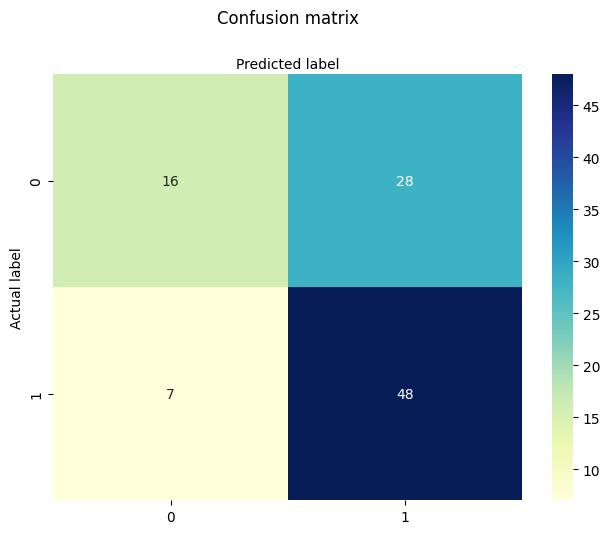

In [820]:
cnf_matrix = metrics.confusion_matrix(y_t, y_t_pred)
cnf_matrix

class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# **Custom Test**

In [821]:
new_url = 'https://www.coursera.org/learn/machine-learning/lecture/1Z0TT/cost-function-formula'

features = []

for i in range(0, 99):
    url = new_url
    label = None

    features.append(featureExtraction(url,label))


#converting the list to dataframe
feature_names = ['url', 'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection','https_Domain', 'label']

df = pd.DataFrame(features, columns= feature_names)


# delete symbols
import re
df["url"] = df["url"].apply(lambda x: re.sub('[/\.;?=https:\']', ' ', x))


# Data selection
url_df = df['url']
domain_df = df['Domain']
depth_df = df['URL_Depth']
feature_df = df[['Have_IP', 'Have_At', 'URL_Length','Redirection','https_Domain']]
label_df = df['label']

depth_arr = np.asarray(depth_df)
depth_arr

import numpy as np
from sklearn import preprocessing

# Reshape depth_arr to a 2D array
depth_arr_2d = np.reshape(depth_arr, (-1, 1))

# Apply StandardScaler
depth_scaler = scaler.transform(depth_arr_2d)
depth_scaler[:5]


import scipy.sparse as sp

# Vectorize URLs
url_vec = vectorizer_url.transform(url_df)


# Vectorize Domains
domain_vec = vectorizer_domain.transform(domain_df)

features_arr = np.asarray(feature_df)



# Convert depth_arr_2d to a sparse matrix
depth_sparse = sp.csr_matrix(depth_arr_2d)

# Concatenate url_vec, domain_vec, and features_arr as sparse matrices
combined_features_arr = sp.hstack((url_vec, domain_vec, sp.csr_matrix(features_arr), depth_sparse), format='csr')

# Make prediction using trained model
prediction = logreg.predict(combined_features_arr)

if prediction[0] == 0:
    print('Legitimate')
elif prediction[0] == 1:
    print('Phishing')
else:
    print('Error')

Phishing
